In [52]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
#from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import scipy as sc
import mpmath
import matplotlib.pyplot as plt

In [53]:
mp_key = "zpmjFe6ZZzl6aqcqeGUTiXhaXzQXDSJl"
mp_id = "mp-961660"

In [54]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    el_bs = m.get_bandstructure_by_material_id(mp_id)
    #el_dos = m.get_dos_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)
#conv_struc = SpacegroupAnalyzer(prim_struc).get_conventional_standard_structure()
#symmops = SpacegroupAnalyzer(conv_struc).get_space_group_operations()

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

# Chaleur spécifique

In [55]:
temperatures = np.arange(0, 1000, 5)
R = 8.314
N_at = len(prim_struc)
ph_cv = np.array([ph_dos.cv(temperatures[i]) for i in range(len(temperatures))]) / (3 * N_at * R)


In [56]:

np.seterr(divide='ignore')


def Cv_Debye(T, theta_D):
    def integrand(x):
        exp = mpmath.exp(x) / (mpmath.exp(x) - 1) ** 2
        return x ** 4 * exp

    result = np.zeros(len(T))
    for i, t in enumerate(T):
        integral_result = sc.integrate.quad(integrand, 0, theta_D / t)
        result[i] = 3 * (T[i] / theta_D) ** 3 * integral_result[0]  #Cv/3N_atR
    return result


def C_vEinstein(T, theta_E):
    result = np.zeros(len(T))
    for i, t in enumerate(T):
        if t != 0:
            frac = theta_E / t
            exp = mpmath.exp(frac) / (mpmath.exp(frac) - 1) ** 2
            result[i] = frac ** 2 * exp  #Cv/3N_atR
        else:
            result[i] = 0
    return result


theta_D = sc.optimize.curve_fit(Cv_Debye, temperatures, ph_cv)[0]
theta_E = sc.optimize.curve_fit(C_vEinstein, temperatures, ph_cv)[0]
print(f"Température d'Einstein = {round(theta_E[0], 2)} K\nTempérature de Debye = {round(theta_D[0], 2)} K")

Température d'Einstein = 331.71 K
Température de Debye = 448.25 K


In [57]:
Cv_D = Cv_Debye(temperatures, theta_D[0])
Cv_E = C_vEinstein(temperatures, theta_E[0])

In [58]:
fig = go.Figure()
scatterData = go.Scatter(x=temperatures, y=ph_cv, name='Données téléchargées')
scatterDebye = go.Scatter(x=temperatures, y=Cv_D, name='Modèle de Debye')
scatterEinstein = go.Scatter(x=temperatures, y=Cv_E, name="Modèle d'Einstein")
fig.add_trace(scatterData)
fig.add_trace(scatterDebye)
fig.add_trace(scatterEinstein)
fig.add_hline(y=1, line_width=2, line_color="violet")
fig.update_layout(
    xaxis={'mirror': True, 'showgrid': False, 'ticks': 'inside', 'ticklen': 10},
    yaxis={'mirror': True, 'showgrid': False, 'ticks': 'inside', 'ticklen': 10},
    xaxis_title="Température",
    yaxis_title="$C_v /3N_{at}R$",
)
fig.show()

# Densité d'état


In [59]:
from scipy.constants import hbar, Boltzmann, pi

omega_D = Boltzmann * theta_D[0] / hbar
omega_E = Boltzmann * theta_E[0] / hbar
print(omega_D / 1e12 / 2 / pi, omega_E / 1e12 / 2 / pi)


def dos_Debye(omega, omega_D):
    if omega < omega_D:
        return 9 * N_at * omega ** 2 / omega_D ** 3
    else:
        return 0


dos_Debye = np.array([dos_Debye(f * 2 * pi, omega_D / 1e12) for f in ph_dos.frequencies])


9.34004018834367 6.911652953743134


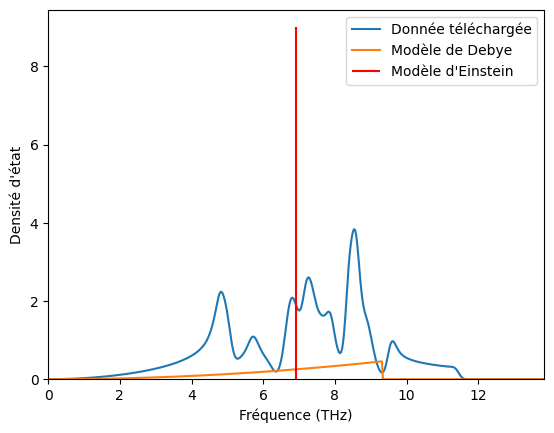

In [62]:
plt.plot(ph_dos.frequencies, ph_dos.densities, label="Donnée téléchargée")
plt.plot(ph_dos.frequencies, dos_Debye, label="Modèle de Debye")
plt.vlines(omega_E / 2 / pi / 1e12, 0, 3 * N_at, colors='red', label="Modèle d'Einstein")
plt.ylabel("Densité d'état")
plt.xlabel("Fréquence (THz)")
plt.legend()
plt.xlim(0,max(ph_dos.frequencies))
plt.ylim(0)
plt.show()